In [1]:
#Install dependencies if running in a new environment
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Geodemographic python example
This notebook contains the workflow for produceding a geodemographic classification in python using k-means clustering. It follows a simplified process, similar to that described in the [2021 OAC Paper](https://rgs-ibg.onlinelibrary.wiley.com/doi/full/10.1111/geoj.12550).

In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from clustergram import Clustergram
import matplotlib.pyplot as plt

#set a  random seed for reproducibility
random_seed = 507

#load the input data from a csv file 
# The names of the columns are not important, BUT;
# the first column should be the geography code (e.g., Output Area or Local Authority District),
# which will be used as the DataFrame index.
# The remaining columns should be variables for clustering, provided as fractions or percentages of the table total.
def load_data(filepath):
    input_df = pd.read_csv(filepath, index_col=0)
    
    # Check for missing values
    missing_values = input_df.isnull().sum().sum()
    if missing_values > 0:
        print(f"Warning: {missing_values} missing values found in input data. Missing values will be replaced with 0.")
        input_df.fillna(0, inplace=True)
    
    return input_df

# File path to the dataset
filepath = "example_oacdata.csv"

# Load the dataset
variable_df = load_data(filepath)
#show first 5 rows of the dataset
variable_df.head()

,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
geo_code,,,,,,,,,,,,,,,,,,,,,
geo_00001,0,71,90,55,59,59,82,87,45,13,...,53,41,49,45,50,53,32,73,67,87
geo_00002,0,78,83,74,67,66,81,97,45,32,...,49,67,65,55,52,64,41,86,70,69
geo_00003,65,94,63,51,79,61,63,92,62,41,...,48,50,42,52,45,67,43,65,88,78
geo_00004,0,79,82,73,75,81,76,100,24,0,...,58,60,58,38,57,62,30,82,70,75
geo_00005,43,70,78,77,87,69,55,98,43,0,...,50,52,63,60,60,58,33,82,67,72


In [20]:
def transform_and_standardize_data(df):
    """Apply inverse hyperbolic sine transform, to account for non-normality
      and then range standardize using min-max scaling to the dataframe."""
    df = np.arcsinh(df)
    df = (df - df.min()) / (df.max() - df.min())
    return df

# Transform the input data
transformed_variable_df = transform_and_standardize_data(variable_df)


In [16]:
import seaborn as sns

def check_corrs(df, corr_threshold = 0.9):
    # Compute the correlation matrix
    corr_matrix = df.corr()
    #plot the correlation matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.show()

    # Find the pairs of highly correlated columns
    # Create a mask to exclude the diagonal (correlation of a column with itself)
    highly_corr = np.where((corr_matrix > corr_threshold ) & (corr_matrix != 1))

    # List to keep track of columns to remove
    columns_to_remove = set()
    # Loop through the pairs and add one column to remove for each pair of high correlation
    for i, j in zip(*highly_corr):
        colname_i = corr_matrix.columns[i]
        colname_j = corr_matrix.columns[j]
        # Keep the column that has the most information or less missing data
        if colname_i not in columns_to_remove:
            columns_to_remove.add(colname_j)  # Add the second column of the pair for removal

    # Remove the columns with high correlation
    df_cleaned = df.drop(columns=columns_to_remove)
    # Show the cleaned dataframe
    print(f"Removed columns: {columns_to_remove}")
    return df_cleaned

# Clustergrams
We produce a clustergram plot to assess an appropriate number of clusters for the supergroups.
For OAC, eight supergroups were created.
Some guidance on interpreting clustergrams and choosing the number of clusters can be found here:
Clustergram Documentation

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.366 seconds.
K=3 fitted in 0.467 seconds.
K=4 fitted in 0.587 seconds.
K=5 fitted in 0.687 seconds.
K=6 fitted in 0.474 seconds.
K=7 fitted in 0.726 seconds.
K=8 fitted in 0.610 seconds.
K=9 fitted in 0.809 seconds.
K=10 fitted in 0.724 seconds.
K=11 fitted in 0.982 seconds.
K=12 fitted in 0.739 seconds.
K=13 fitted in 0.747 seconds.
K=14 fitted in 0.889 seconds.


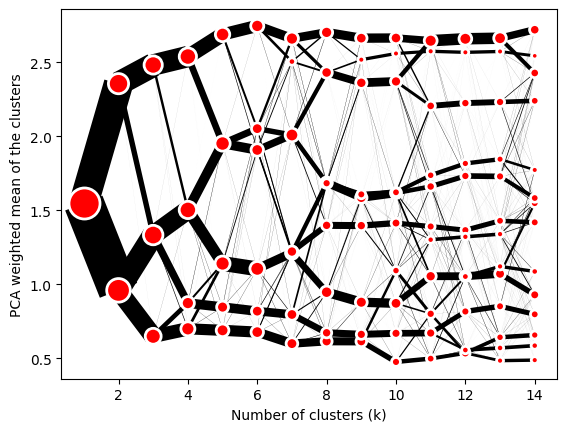

In [21]:

def create_clustergram(df, n_init, save_loc, random_seed=random_seed):
    """
    Create and save a clustergram for evaluating k-means clustering solutions.

    The clustergram visualizes clustering stability and helps identify the optimal 
    number of clusters by performed the k-means algorithm for a range of cluster
    numbers.
    Since k-means is sensitive to initialization, `n_init` determines the number of 
    times the algorithm runs with different centroid seeds. The final result is the 
    best outcome based on inertia/WCSS (within-cluster sum of squares.

    Parameters:
    df (pd.DataFrame or np.ndarray): The input data for clustering.
    n_init (int): Number of k-means runs with different initial centroid seeds. 
                  Higher values (e.g., ~1000) improve solution stability but increase runtime.
    save_loc (str): File path to save the clustergram plot.
    random_seed (int, optional): Random seed for reproducibility.
    """
    cgram = Clustergram(range(1, 15), n_init=n_init, random_state=random_seed)  # Initialize clustergram model
    cgram.fit(df)  # Fit model to data
    cgram.plot()  # Generate plot
    plt.savefig(save_loc)  # Save figure
    plt.show()  # Display plot

# Example usage
n_init = 1  # Use a low value for quick testing, increase (~100) for final results
create_clustergram(transformed_variable_df, n_init, save_loc="plots/supergroup_clustergram.png")


In [ ]:
import os
import pandas as pd
from sklearn.cluster import KMeans

def run_kmeans(input_df, num_clusters, n_init, output_filepath, random_seed=None):
    """
    Run K-means clustering on the input dataset and save the cluster assignments.

    This function applies K-means clustering to the provided dataset, assigns cluster 
    labels to each row, and saves the cluster assignments as a lookup table.

    Parameters:
    input_df (pd.DataFrame): The input dataset to be clustered.
    num_clusters (int): The number of clusters (K) to create.
    n_init (int): Number of times the K-means algorithm runs with different initial 
                  centroid seeds. The best result based on inertia/WCSS is chosen. 
                  A higher value (e.g., ~1000) is recommended for final results, 
                  but a lower value can be used for testing.
    output_filepath (str): Path to save the resulting cluster assignments.
    random_seed (int, optional): Random seed for reproducibility.

    Returns:
    pd.DataFrame: The input DataFrame with an added 'cluster' column containing 
                  the assigned cluster for each row.
    """
    # Initialize the K-means model
    kmeans_model = KMeans(n_clusters=num_clusters, max_iter=1000, random_state=random_seed, n_init=n_init)
    
    # Fit the model and assign clusters
    input_df['cluster'] = kmeans_model.fit_predict(input_df)

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_filepath), exist_ok=True)

    # Save the cluster assignments to a CSV file
    input_df[['cluster']].to_csv(output_filepath, index=False)

    # Show the first few rows of the assigned clusters
    print(f"K-means clusters:\n{input_df[['cluster']].head()}")

    return input_df

# Define the number of clusters (K). Choose K based on the clustergram plot.
num_clusters = 8  
output_filepath = "outputs/supergroups_clusteroutput.csv"

# Run K-means clustering
supergrouped_variable_df = run_kmeans(transformed_variable_df, num_clusters, n_init=1, output_filepath = output_filepath, random_seed=random_seed)

#supregrouped_variable_df contains the cluster assignments for each row in the input data, and the input data itself.
supergrouped_variable_df.head()


K-means clusters:
           cluster
geo_code          
geo_00001        2
geo_00002        2
geo_00003        7
geo_00004        4
geo_00005        0


,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,...,v52,v53,v54,v55,v56,v57,v58,v59,v60,cluster
geo_code,,,,,,,,,,,,,,,,,,,,,
geo_00001,0.000000,0.935364,0.981978,0.888862,0.902136,0.900424,0.962547,0.856059,0.849310,0.617561,...,0.831745,0.865379,0.849310,0.869191,0.880186,0.784986,0.944206,0.924420,0.973717,2
geo_00002,0.000000,0.953109,0.966668,0.944966,0.926177,0.921582,0.960231,0.968517,0.849310,0.787991,...,0.924420,0.918701,0.887176,0.876592,0.915775,0.831745,0.975254,0.932687,0.929971,2
geo_00003,0.918701,0.988322,0.914538,0.874586,0.957329,0.906715,0.912803,0.913816,0.909784,0.834928,...,0.869191,0.836291,0.876592,0.849310,0.924420,0.840731,0.922217,0.975874,0.953109,7
geo_00004,0.000000,0.955513,0.964376,0.942394,0.947504,0.960231,0.948207,1.000000,0.730726,0.000000,...,0.903596,0.897198,0.817408,0.893916,0.909784,0.772812,0.966231,0.932687,0.945707,4
geo_00005,0.840731,0.932687,0.954920,0.952480,0.975568,0.929971,0.887176,0.979118,0.840731,0.000000,...,0.876592,0.912803,0.903596,0.903596,0.897198,0.790792,0.966231,0.924420,0.938003,0


# Subgroups
For OAC the supergroup clusters created above are split further into groups and subgroups by applying the above process iteratively. 
Example code for creating the subclusters is below

Cluster: 0, 13610 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster0.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.178 seconds.
K=3 fitted in 0.208 seconds.
K=4 fitted in 0.252 seconds.
K=5 fitted in 0.277 seconds.
K=6 fitted in 0.278 seconds.
K=7 fitted in 0.266 seconds.
K=8 fitted in 0.392 seconds.
K=9 fitted in 0.297 seconds.
K=10 fitted in 0.266 seconds.
K=11 fitted in 0.287 seconds.
K=12 fitted in 0.266 seconds.
K=13 fitted in 0.251 seconds.
K=14 fitted in 0.277 seconds.


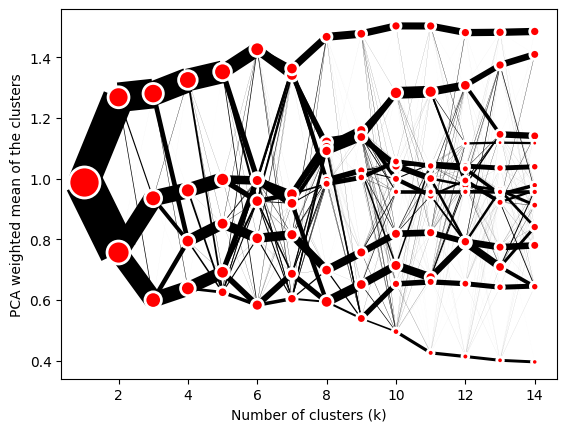

Cluster: 1, 8366 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster1.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.165 seconds.
K=3 fitted in 0.180 seconds.
K=4 fitted in 0.170 seconds.
K=5 fitted in 0.177 seconds.
K=6 fitted in 0.163 seconds.
K=7 fitted in 0.258 seconds.
K=8 fitted in 0.300 seconds.
K=9 fitted in 0.271 seconds.
K=10 fitted in 0.217 seconds.
K=11 fitted in 0.228 seconds.
K=12 fitted in 0.239 seconds.
K=13 fitted in 0.277 seconds.
K=14 fitted in 0.219 seconds.


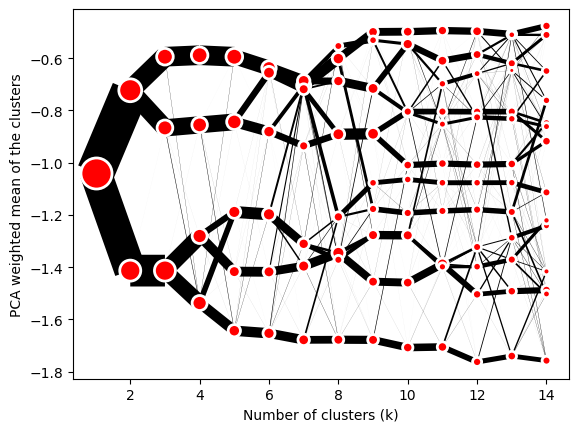

Cluster: 2, 15011 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster2.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.202 seconds.
K=3 fitted in 0.184 seconds.
K=4 fitted in 0.169 seconds.
K=5 fitted in 0.189 seconds.
K=6 fitted in 0.204 seconds.
K=7 fitted in 0.196 seconds.
K=8 fitted in 0.258 seconds.
K=9 fitted in 0.248 seconds.
K=10 fitted in 0.283 seconds.
K=11 fitted in 0.277 seconds.
K=12 fitted in 0.291 seconds.
K=13 fitted in 0.350 seconds.
K=14 fitted in 0.319 seconds.


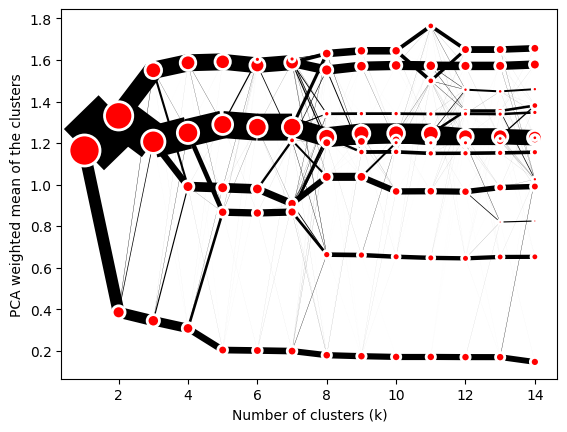

Cluster: 3, 15650 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster3.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.185 seconds.
K=3 fitted in 0.184 seconds.
K=4 fitted in 0.178 seconds.
K=5 fitted in 0.156 seconds.
K=6 fitted in 0.227 seconds.
K=7 fitted in 0.298 seconds.
K=8 fitted in 0.297 seconds.
K=9 fitted in 0.392 seconds.
K=10 fitted in 0.296 seconds.
K=11 fitted in 0.265 seconds.
K=12 fitted in 0.273 seconds.
K=13 fitted in 0.262 seconds.
K=14 fitted in 0.327 seconds.


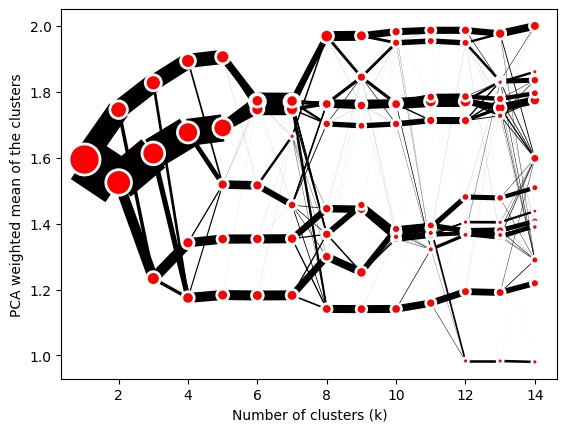

Cluster: 4, 20590 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster4.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.267 seconds.
K=3 fitted in 0.202 seconds.
K=4 fitted in 0.210 seconds.
K=5 fitted in 0.263 seconds.
K=6 fitted in 0.281 seconds.
K=7 fitted in 0.238 seconds.
K=8 fitted in 0.251 seconds.
K=9 fitted in 0.312 seconds.
K=10 fitted in 0.302 seconds.
K=11 fitted in 0.336 seconds.
K=12 fitted in 0.396 seconds.
K=13 fitted in 0.373 seconds.
K=14 fitted in 0.365 seconds.


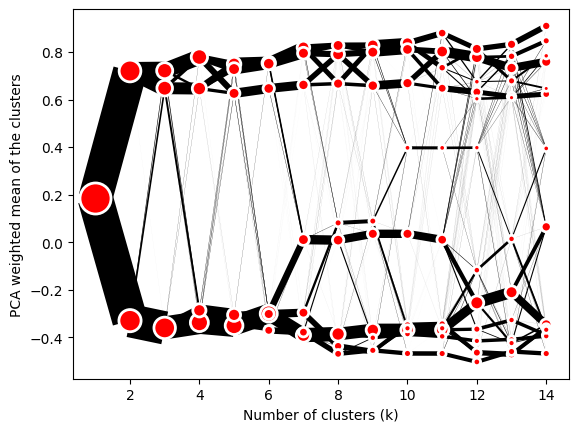

Cluster: 5, 2682 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster5.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.127 seconds.
K=3 fitted in 0.182 seconds.
K=4 fitted in 0.048 seconds.
K=5 fitted in 0.091 seconds.
K=6 fitted in 0.092 seconds.
K=7 fitted in 0.095 seconds.
K=8 fitted in 0.205 seconds.
K=9 fitted in 0.064 seconds.
K=10 fitted in 0.129 seconds.
K=11 fitted in 0.138 seconds.
K=12 fitted in 0.134 seconds.
K=13 fitted in 0.103 seconds.
K=14 fitted in 0.076 seconds.


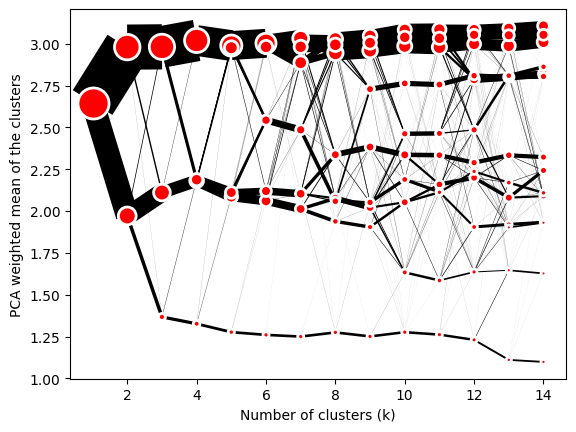

Cluster: 6, 10718 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster6.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.162 seconds.
K=3 fitted in 0.201 seconds.
K=4 fitted in 0.219 seconds.
K=5 fitted in 0.289 seconds.
K=6 fitted in 0.314 seconds.
K=7 fitted in 0.320 seconds.
K=8 fitted in 0.321 seconds.
K=9 fitted in 0.688 seconds.
K=10 fitted in 0.319 seconds.
K=11 fitted in 0.328 seconds.
K=12 fitted in 0.268 seconds.
K=13 fitted in 0.279 seconds.
K=14 fitted in 0.310 seconds.


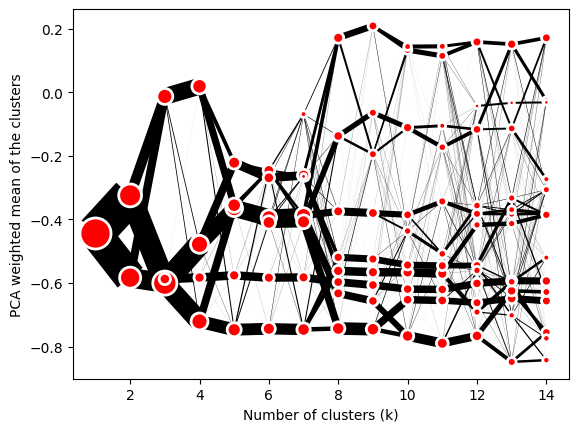

Cluster: 7, 13373 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster7.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.159 seconds.
K=3 fitted in 0.227 seconds.
K=4 fitted in 0.243 seconds.
K=5 fitted in 0.244 seconds.
K=6 fitted in 0.234 seconds.
K=7 fitted in 0.230 seconds.
K=8 fitted in 0.254 seconds.
K=9 fitted in 0.303 seconds.
K=10 fitted in 0.263 seconds.
K=11 fitted in 0.278 seconds.
K=12 fitted in 0.269 seconds.
K=13 fitted in 0.374 seconds.
K=14 fitted in 0.323 seconds.


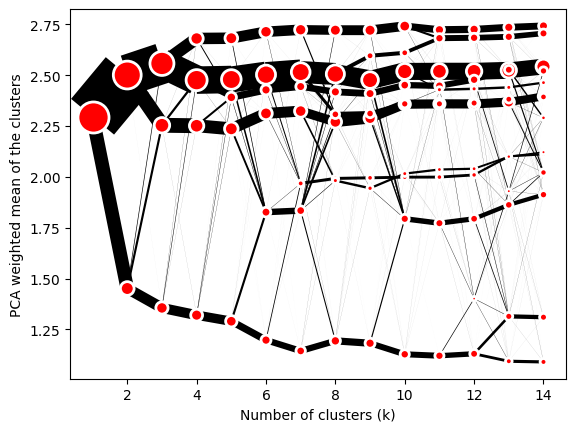

In [27]:
import os

def create_subcluster_clustergrams(output_df, num_clusters, n_init=1):
    """
    Generate and save clustergrams for each supercluster.
    This function loops through the existing clusters and creates a clustergram 
    for each
    Parameters:
    output_df (pd.DataFrame): DataFrame containing cluster assignments.
    num_clusters (int): The total number of clusters to iterate over.
    n_init (int, optional): Number of times K-means runs with different centroid seeds.
                            Defaults to 1 for quick testing.

    """
    save_dir = "plots" #directory to save the clustergrams
    os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists

    for cluster in range(num_clusters):
        # Select rows corresponding to the current cluster, dropping the 'cluster' column
        cluster_df = output_df.query(f"cluster == {cluster}").drop(columns='cluster')

        print(f"Cluster: {cluster}, {len(cluster_df)} geographies in cluster")

        if cluster_df.empty:
            print(f"Skipping cluster {cluster} as it has no data.")
            continue

        # Define save location
        save_loc = os.path.join(save_dir, f"subcluster_clustergram_cluster{cluster}.png")
        print(f"Saving clustergram to {save_loc}")

        # Generate clustergram
        create_clustergram(cluster_df, n_init=n_init, save_loc=save_loc)

# Example usage
create_subcluster_clustergrams(supergrouped_variable_df, num_clusters, n_init=1)



In [28]:

def run_subclustering(output_df: pd.DataFrame, subcluster_nums: list, num_clusters: int, n_init: int = 1) -> pd.DataFrame:
    """
    Runs subclustering for each supergroup using KMeans and returns a modified DataFrame with subcluster labels.
    
    Parameters:
    - output_df (pd.DataFrame): The original DataFrame containing data and cluster assignments.
    - subcluster_nums (list): A list specifying the number of subclusters to split each supergroup into.
    - num_clusters (int): The total number of supergroups.
    - n_init (int, optional): The number of times KMeans will be initialized. Defaults to 1.

    Returns:
    - pd.DataFrame: A new the output dataFrame with an added 'subcluster' column.
    """
    if len(subcluster_nums) != num_clusters:
        raise ValueError(f"Length of subcluster_nums ({len(subcluster_nums)}) does not match num_clusters ({num_clusters}).")

    # Work on a copy of the DataFrame to prevent unintended modifications
    modified_df = output_df.copy()

    for cluster, num_subclusters in zip(range(num_clusters), subcluster_nums):
        print(f"Clustering supergroup {cluster} into {num_subclusters} subclusters.")

        # Select rows corresponding to the current cluster, drop the cluster column before clustering
        cluster_df = modified_df.query(f"cluster == {cluster}").drop(columns='cluster')

        # Run KMeans clustering for the selected supergroup
        subcluster_output_df = run_kmeans(
            cluster_df, 
            num_subclusters, 
            n_init=n_init, 
            output_filepath=f"outputs/supergroup{cluster}_subclusteroutput.csv"
        )

        # Convert 0,1,2,... to a, b, c, ...
        subcluster_output_df['subcluster'] = [str(cluster) + chr(97 + i) for i in subcluster_output_df['cluster']]

        # Update the modified DataFrame with subclustering results
        modified_df.loc[cluster_df.index, 'subcluster'] = subcluster_output_df['subcluster']

    # Save the final output
    modified_df.to_csv("outputs/subgroups_clusteroutput.csv")
    print("Final output saved to outputs/subgroups_clusteroutput.csv")

    return modified_df  # Return the modified DataFrame without altering the original


#run the subclustering for each of the supergroups
# We can now select the number of subclusters to split each of the supergroups into using the clustergrams above.
# For this example, we choose three subclusters for each supergroup.
# The length of the list must match num_clusters (the number of supergroups).
subcluster_nums = [3, 3, 3, 3, 3, 3, 3, 3]
# subcluster_nums = [2, 4, 2, 2, 5, 2, 3, 3]

subgrouped_variable_df = run_subclustering(supergrouped_variable_df, subcluster_nums, num_clusters=num_clusters, n_init=1)


Clustering supergroup 0 into 3 subclusters.
K-means clusters:
           cluster
geo_code          
geo_00005        0
geo_00007        1
geo_00010        0
geo_00030        0
geo_00051        1
Clustering supergroup 1 into 3 subclusters.


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values